# Introduction to Regularization

-----

In this notebook, we introduce the concept of regularization. Regularization is a technique that is used to prevent [overfitting][wo] when computing regression models. Overfitting is a general problem that should be a major concern for any every data scientist. In general, overfitting occurs when a model predicts extremely well for a training data set but fails to generalize with the same performance to a testing data set.

For example, when using decision trees, overfitting can occur when the number of training data points in a leaf node is very small. This is beecause the tree will predicts (almost) exactly for these data. For linear or logistic regression models, however, overfitting can occur when the model becomes overly complex, for example, when the model has too many parameters or coefficients when compared to the size of the data set being modeled. This can occur when a model fits both the underlying signal and the noise in a training data set

The fundamental idea in regularization is to add additional information to the model selection process in order to force a regression model to have a specific behavior. For example, we can force the model coefficients to preferentially take on smaller values, or we can force some (or most) of the coefficients to become zero, thus effectively reducing the number of model coefficients. The most popular forms of regularization accomplish this by adding a penalty term to the **cost** (or loss) function that the models minimize in order to determine the optimal model parameters.

-----
[wo]: https://en.wikipedia.org/wiki/Overfitting

## Table of Contents

[Data](#Data)

[Polynomial Fitting](#Polynomial-Fitting)
- [Optimal Fitting](#Optimal-Fitting)

[Ridge Regression](#Ridge-Regression)

[Lasso Regression](#Lasso-Regression)

[Elastic Net Regression](#Elastic-Net-Regression)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Data

Before exploring different techniques for performing regularization, we first need a data set with which we can demonstrate overfitting, and then how regularization can . For this purpose, we will generate simulated data from a model that can easily be altered as needed. The following Code cell defines `theModel` function, which generates a set of independent variables, `x`, along with a signal, which is non-linear, and a noise array, the strength of which can be adjusted via the `sigma` parameter. These are combined together into the dependent array, `y`, which is what a regression model attempts to fit. To ensure reproducibility, we set the `RandomState` at the start of this cell. Changing this value will produce different data, which will affect the results of all subsequent model fits.

-----

In [2]:
# We define a simple function to fit.

rng = np.random.RandomState(23)

def theModel(xmin=0.01, xmax = 9.99, num=100):
    
    # Noise scale
    sigma = 0.75

    # Sample points
    x = np.linspace(xmin, xmax, num)
    
    # Define signal and noise arrays
    signal = 25. - np.sqrt(x) * np.cos(x) - np.sqrt(x)
    noise = sigma * rng.randn(len(x))
    
    return(x, signal, noise)

-----

To demonstrate the underlying model and the data generated from the model, we plot the original function and the signal plus noise in the following Code cell. We define the number of points to sample from the model, which can be changed to explore the impact of regression and regularization at the start of the Code cell. After that we plot the function (or signal) along with the observed (or sampled) points.


----

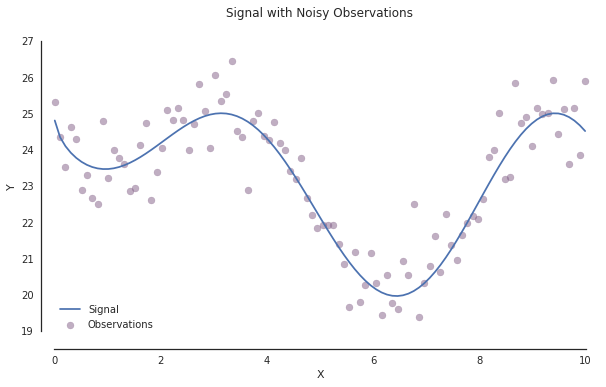

In [3]:
# Make data
x, s, n = theModel(num = 100)

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot signal and observations points
axs.plot(x, s, label='Signal')
axs.scatter(x, s + n, c=sns.xkcd_rgb["dusty purple"],
            alpha=0.5, label='Observations')

# Dcorate plot
axs.set(title='Signal with Noisy Observations',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

##  Polynomial Fitting

A simple first step is to see how different polynomial functions fit our data. To fit a polynomial we can use the [`PolynomialFeatures`][skpf] estimator to generate a new feature matrix that transforms the input array (in our case the sample independent variables) into polynomial terms. We can apply the [`LinearRegression`][sklr] estimator to this new feature matrix to compute the best-fit linear model over the polynomial features. 

In the following Code cell, we demonstrate the use of the `PolynomialFeatures` estimator to create a a transformation from an input data point, and the polynomial feature matrix. We first create the estimator, in this specific example, we generate a fifth order polynomial. We fit this to the sample data, and display both the new feature names, which are the polynomial terms, and demonstrate the effect of transforming the integer `2`, which creates and array of values corresponding to `2` raised to the powers: 0, 1, 2, 3, 4, and 5.


-----
[skpf]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
[sklr]: http://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Number of points to use for fitting polynomial features
num_pts = 20

# Create fake data
x_sample = np.zeros(num_pts).reshape(num_pts, 1)

# Create polynomial feature
pp = PolynomialFeatures(5).fit(x_sample)
print('Polynomial terms:', pp.get_feature_names())

# Display polynomial transformation
print(pp.transform(2))

Polynomial terms: ['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5']
[[  1.   2.   4.   8.  16.  32.]]


-----

Now that we can transform our independent array into a polynomial feature matrix, we can easily generate and fit different order polynomials to the simulated data. As we increase he order of the polynomial being fit to the data, we introduce additional degrees of freedom, which simply means more flexibility. This results in better fits to the signal, but also the likelihood that we fit intrinsic scatter (or variance) in the data. While this can be a good thing, left unchecked we can reach a position where our model _overfits_ the data. In this case, our model effectively captures the signal and the noise, which is not what we desire. 

We can demonstrate this issue by fitting a a number of polynomials of different order to our simple data set and visualizing the tendency of higher order polynomials to _capture the variance_. The following Code cell generates our dependent variable, and splits the data into training and testing samples. Next, use a pipeline to simplify the application of the `PolynomialFeatures` and `LinearRegression` estimators to the data, all of which is wrapped in a loop that simplifies exploring the effect of different orders of polynomial fits. We distinguish training data as _blue points_ and testing data as _red points_.

The final plot displays the original data, and different polynomial fits to the data to compare the quality of the fit as a function of polynomial order. From the figure, it is clear that a first and even a third order polynomial fail to capture the full signal. Formally, this is known as underfitting, as our model fails to capture the full signal. On the other hand, the highest two polynomial fits: twenty-first and twenty-third order polynomials, capture the signal plus some of the noise. Formally, this is a demonstration of overfitting, as the model goes beyond the signal to capture the noise. In this case, the seventh order polynomial fit seems to capture the underlying signal, at least over the range considered in this demonstration.

-----

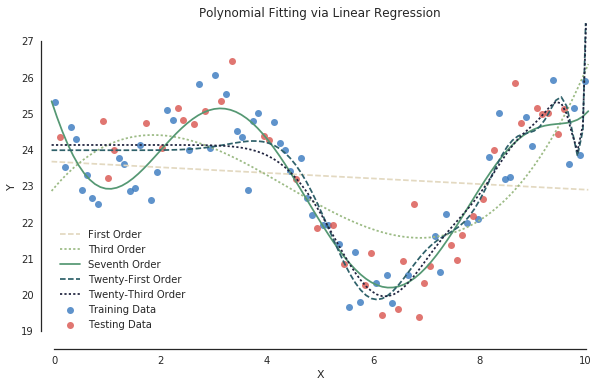

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline as mp
from sklearn.model_selection import train_test_split

# Define observation array
y = s + n

# Set the training fraction and maximum degree of polynomical fit
test_frac = 0.4

# Ready data set for cross-validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot training and testing data
ax = sns.regplot(x_train, y_train, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["windows blue"], label="Training Data")
ax = sns.regplot(x_test, y_test, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["pale red"], label="Testing Data")

# Polynomial degrees
degs = np.array([1, 3, 7, 21, 23])

# Define label list (should match polynomial degrees)
lbls = ['First', 'Third', 'Seventh', 
        'Twenty-First', 'Twenty-Third']

# Define linestyle list
lst = ['--', ':', '-', '--', ':', '-.']

# Define colormap for polynomial fits
cmp = sns.cubehelix_palette(len(degs), start=.25, rot=-.75)

# Sample predict points
xf = np.linspace(-0.05, 10.05, 100)

# Iterate over polynomial fits
for idx, deg in enumerate(degs):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)

    # Plot predicted points
    axs.plot(xf, est.predict(xf[:, np.newaxis]), 
             c=cmp[idx], linestyle=lst[idx],
             label='{0} Order'.format(lbls[idx]))
    
# Decorate plot
axs.set(title='Polynomial Fitting via Linear Regression',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----
Not only does the previous figure demonstrate both underfitting and overfitting to the training data (the blue points), but it also demonstrates the inability of these models to generalize to the testing data (the red points). While the seventh order polynomial does a good job modeling the signal over the region of interest (0 - 10), it is unlikely to do well outside this region. This demonstrates the importance of _interpolation_, where a model is used over its support (or the data upon which it as defined) versus _extrapolation_, where a model is used to predict outside its support. In this example the support spans 0-10.

-----

[[Back to TOC]](#Table-of-Contents)

### Optimal Fitting

We can automate this process, by computing a performance metric for each polynomial fit to automatically determine which polynomial model best approximates our data. In the following Code cell, we use the mean squared error (or MSE) to compute the performance of different polynomial models in fitting the training and testing data. In this case, we see that, from the **test** data, after a fifth order polynomial fit (in general, the data is random and thus the results can vary) the accuracy remains fairly flat. In addition, note how the MSE is higher for the testing data than for the training data. This is a common situation, as the model performs worse on unseen data. The MSE on the testing data also starts to rise for higher order polynomials indicating our performance is degrading, which is often a sign of overfitting.

In general, however, we don't (or can't) fit different polynomials and compare the results. Thus, while this example is demonstrative of the problem of overfitting and provides an explicit demonstration of the optimal fitting function, we will want to explore more advanced techniques.

----

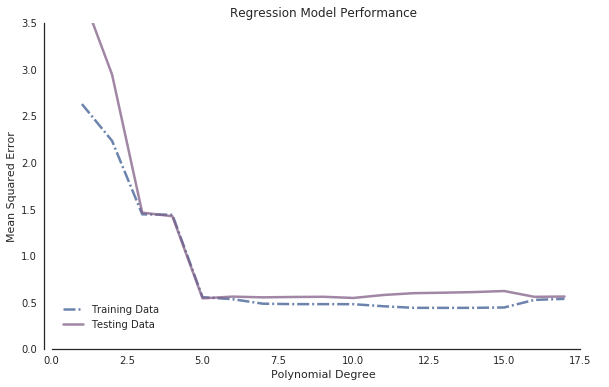

In [6]:
from sklearn.metrics import mean_squared_error as mse

# Max Polynomial order
max_deg = 17

# Initialize arrays
train_error = np.empty(max_deg)
test_error = np.empty(max_deg)

# Generate polynomial fits and compute MSE for
# training and testing data sets
for deg in range(1, max_deg + 1):
    est = mp(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)
    train_error[deg - 1] = mse(y_train, est.predict(x_train[:, np.newaxis]))
    test_error[deg - 1] = mse(y_test, est.predict(x_test[:, np.newaxis]))

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot the training and testing performance
xp = np.arange(1, max_deg + 1)
axs.plot(xp, train_error, linestyle='-.', lw=2.5,
         color=sns.xkcd_rgb["denim blue"], alpha = 0.75,
         label='Training Data')
axs.plot(xp, test_error, linestyle='-', lw=2.5,
         color=sns.xkcd_rgb["dusty purple"], alpha = 0.75,
         label='Testing Data')

# Decorate plot
axs.set(title='Regression Model Performance',
       xlabel='Polynomial Degree', xlim=(-0.25, 18.25),
       ylabel='Mean Squared Error', ylim=(0., 3.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Ridge Regression

The first technique that we will demonstrate to reduce the likelihood of overfitting is [ridge regression][rr], or Tikhonov regularization. Ridge regression adds a penalty term, which is the L2-norm of the regression coefficients, to the fitting process to emphasize _smooth_ fits rather than _wildly fluctuating_ fits. You may recall from an earlier discussion on distance metrics that the L2-norm corresponds to the Euclidean distance. In the scikit learn library, the [`Ridge`][skr] estimator performs ridge regression, and the L2 norm is encoded by the `alpha` parameter. 

In the following example, we demonstrate how to employ ridge regression on our sample data set for a seventeenth order polynomial with different values of `alpha`. After the code, the different coefficients for each different value of the `alpha` parameter are displayed, along with the different fits. For space constraints, we only print out the first seven polynomial coefficients (recall that a seventh order polynomial nicely represented the signal). From this example, you should notice two things:

1. as `alpha` increases, the coefficients are all driven to smaller values, and
2. as `alpha` increases, the polynomial function becomes more smooth (which of course results from the smaller coefficients.

Thus, ridge regression leads to _dense solutions_ since most coefficients are non-zero.

-----
[rr]: https://en.wikipedia.org/wiki/Tikhonov_regularization
[skr]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Select Coefficients:

alpha           x      x**2      x**3      x**4      x**5      x**6      x**7
-----------------------------------------------------------------------------
0.0e+00     -0.44     -0.03    -66.01    227.60   -355.73    330.15   -202.19
1.0e-06     -2.78     -6.57     14.53    -10.78      3.67     -0.20     -0.33
1.0e-04     -4.69      1.28      2.04     -1.10      0.01      0.11     -0.02
1.0e-02     -3.92      0.47      1.55      0.26     -0.99      0.49     -0.10
1.0e+00     -0.84     -0.37      0.10      0.33      0.10     -0.26      0.12


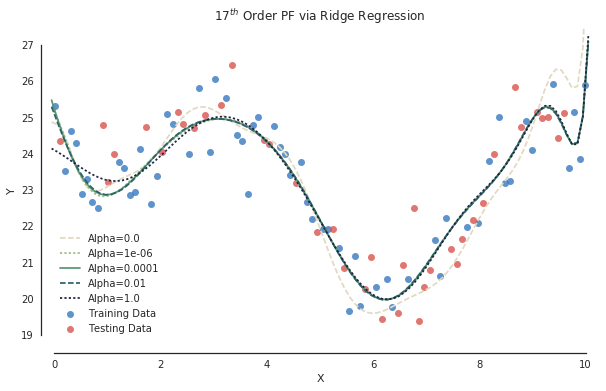

In [7]:
# Use Ridge Regression
from sklearn.linear_model import Ridge

# Define different alpha values for different fits
alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot training and testing data
ax = sns.regplot(x_train, y_train, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["windows blue"], label="Training Data")
ax = sns.regplot(x_test, y_test, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["pale red"], label="Testing Data")


# Display fit coefficients
print("Select Coefficients:\n")
print('alpha           x      x**2      x**3      x**4      x**5      x**6      x**7')
print('-----------------------------------------------------------------------------')

# Define colormap for polynomial fits
cmp = sns.cubehelix_palette(len(alpha), start=.25, rot=-.75)

# Sample predict points
xf = np.linspace(-0.05,10.05,100)

# Define degree of polynomial fit
deg = 17

# Iterate over alpha values
for idx, al in enumerate(alpha):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg), Ridge(alpha=al))
    est.fit(x_train[:, np.newaxis], y_train)

    # Plot predicted points
    axs.plot(xf, est.predict(xf[:, np.newaxis]), 
             c=cmp[idx], linestyle=lst[idx],
             label=f'Alpha={al}')
    
    # Extract fit coefficients
    cfs = est.steps[-1][1].coef_.ravel()
    
    # Display polynomial (we only show the first seven coefficients)
    print(f'{al:4.1e}', end='')
    for val in cfs[1:8]:
        print(f'{val:10.2f}', end='')
    print()

# Decorate plot
axs.set(title='$17^{th}$ Order PF via Ridge Regression',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Lasso Regularization

A second type of regularization is known as [Lasso regularization][lr], short for least absolute shrinkage and selection operator, where an L1-norm is used as a penalty. In this case, only a subset of the original model coefficients are selected while the remaining coefficients are set to zero. This condition is enforced by requiring the sum of the absolute values of the coefficients to be less than a fixed value. Thus the Lasso technique leads to _sparse solutions_.

In the scikit learn library, the [`Lasso`][skl] estimator implements this technique, and once again the `alpha` parameter encodes the normalization condition. Increasing the `alpha` parameter drives more coefficients to zero, such that when `alpha = 1.0`, only one coefficient remains non-zero. In the following example, we compute a Lasso regularization with Linear regression for a high order polynomial function (specifically seventeenth-order) for different values of `alpha`. As displayed in the following table and figure, as `alpha` increases, the non-zero polynomial coefficients become progressively fewer, reducing the chance of overfitting. Note, once again we only display the coefficients for the first seven polynomial terms due to space constraints.

-----

[lr]: https://en.wikipedia.org/wiki/Lasso_(statistics)
[skl]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Select Coefficients:

alpha           x      x**2      x**3      x**4      x**5      x**6      x**7
-----------------------------------------------------------------------------
1.0e-04      1.89     -0.44     -0.01      0.00      0.00      0.00      0.00
1.0e-02      1.77     -0.41     -0.01      0.00      0.00      0.00      0.00
1.0e-01      0.69     -0.08     -0.04      0.00      0.00      0.00      0.00
1.0e+00      0.00      0.00     -0.02     -0.00      0.00      0.00      0.00


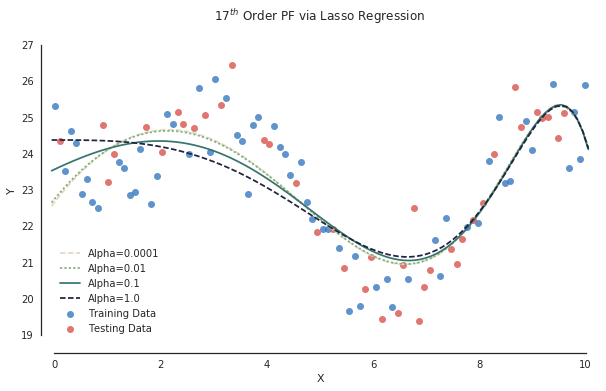

In [8]:
from sklearn.linear_model import Lasso

# Show different alpha fits. Compare fit coeeficients.
alpha = [1E-4, 1E-2, 0.1, 1.0]

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot training and testing data
ax = sns.regplot(x_train, y_train, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["windows blue"], label="Training Data")
ax = sns.regplot(x_test, y_test, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["pale red"], label="Testing Data")

# Display coefficients
print("Select Coefficients:\n")
print('alpha           x      x**2      x**3      x**4      x**5      x**6      x**7')
print('-----------------------------------------------------------------------------')

# Define colormap for polynomial fits
cmp = sns.cubehelix_palette(len(alpha), start=.25, rot=-.75)

# Sample predict points
xf = np.linspace(-0.05,10.05,100)

# Define degree of polynomial fit
deg = 17

# Iterate over alpha values
for idx, al in enumerate(alpha):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg), Lasso(alpha=al, fit_intercept=True))
    est.fit(x_train[:, np.newaxis], y_train)

    # Plot predicted points
    axs.plot(xf, est.predict(xf[:, np.newaxis]), 
             c=cmp[idx], linestyle=lst[idx],
             label=f'Alpha={al}')
    
    # Extract fit coefficients
    cfs = est.steps[-1][1].coef_.ravel()
    
    # Display polynomial (we only show the first seven coefficients)
    print(f'{al:4.1e}', end='')
    for val in cfs[1:8]:
        print(f'{val:10.2f}', end='')
    print()

# Decorate plot
axs.set(title='$17^{th}$ Order PF via Lasso Regression',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)


-----

[[Back to TOC]](#Table-of-Contents)

## Elastic Net

In some cases, one might wish to employ both regularization techniques.  This approach is known as [Elastic Net][wen], which is implemented in the scikit learn library by the [`ElasticNet`][ske] estimator. This estimator is typically used with two parameters: `alpha` and `l1_ratio`. The `alpha` term is what multiplies the normalization computation for both Ridge and Lasso regularization. The `l1ratio` term specifies the relative mix between the two techniques, with a value of 1 corresponding to pure _Lasso_, and smaller values indicating a mixture.

In the following example, we demonstrate the use of `ElasticNet` by employing the same example as before but in this case with a fixed value for the `l1_ratio` term and allowing the `alpha` term to vary. As before, increasing `alpha` leads to a more constrained model fit, as shown in the fit coefficients, which become both progressively smaller and increasingly more likely to be set to zero.

-----

[wen]: https://en.wikipedia.org/wiki/Elastic_net_regularization
[ske]: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

Select Coefficients:

alpha           x      x**2      x**3      x**4      x**5      x**6      x**7
-----------------------------------------------------------------------------
1.0e-04      1.89     -0.44     -0.01      0.00      0.00      0.00      0.00
1.0e-02      1.75     -0.40     -0.01      0.00      0.00      0.00      0.00
1.0e-01      0.84     -0.13     -0.03      0.00      0.00      0.00      0.00
1.0e+00      0.00      0.04     -0.03      0.00      0.00      0.00      0.00


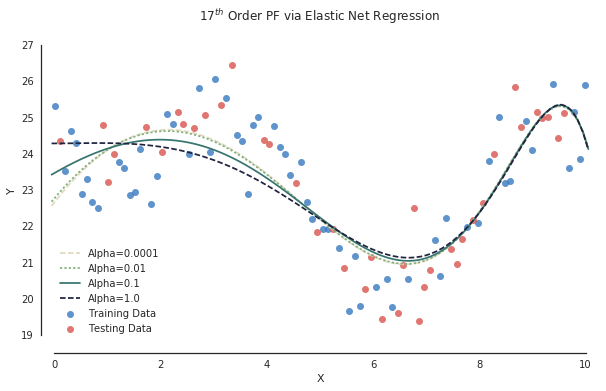

In [9]:
# Use Lasso
from sklearn.linear_model import ElasticNet

# Set L1/L2 ratio
l12_ratio = 0.5

# Show different alpha fits. Compare fit coeeficients.
alpha = [1E-4, 1E-2, 0.1, 1.0]

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot training and testing data
ax = sns.regplot(x_train, y_train, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["windows blue"], label="Training Data")
ax = sns.regplot(x_test, y_test, ax=axs, fit_reg=False, 
                 color=sns.xkcd_rgb["pale red"], label="Testing Data")

# Display coefficients
print("Select Coefficients:\n")
print('alpha           x      x**2      x**3      x**4      x**5      x**6      x**7')
print('-----------------------------------------------------------------------------')

# Define colormap for polynomial fits
cmp = sns.cubehelix_palette(len(alpha), start=.25, rot=-.75)

# Sample predict points
xf = np.linspace(-0.05,10.05,100)

# Define degree of polynomial fit
deg = 17

# Iterate over alpha values
for idx, al in enumerate(alpha):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg), ElasticNet(alpha=al, l1_ratio=l12_ratio))
    est.fit(x_train[:, np.newaxis], y_train)

    # Plot predicted points
    axs.plot(xf, est.predict(xf[:, np.newaxis]), 
             c=cmp[idx], linestyle=lst[idx],
             label=f'Alpha={al}')
    
    # Extract fit coefficients
    cfs = est.steps[-1][1].coef_.ravel()
    
    # Display polynomial (we only show the first seven coefficients)
    print(f'{al:4.1e}', end='')
    for val in cfs[1:8]:
        print(f'{val:10.2f}', end='')
    print()

# Decorate plot
axs.set(title='$17^{th}$ Order PF via Elastic Net Regression',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used Ridge, Lasso, and ElasticNet regularization to model our original signal plus noise. Now that you have run these code cells, try making the following changes and see if you can explain what has changed.

2. Change the polynomial fit in all three examples from seventeenth order to twenty-second order.
3. Try using a higher and lower value for `l12_ratio` hyperparameter with ElasticNet.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Wikipedia article on [Lasso][1] Regression
23. Official [Lasso][23] webpage
1. Wikipedia article on [Ridge][3] Regression
32. Wikipedia article on [ElasticNet][21] Regression

-----

[1]: https://en.wikipedia.org/wiki/Lasso_(statistics)
[23]: http://statweb.stanford.edu/~tibs/lasso.html
[3]: https://en.wikipedia.org/wiki/Tikhonov_regularization
[21]: https://en.wikipedia.org/wiki/Elastic_net_regularization

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 